# AGAD - Example Notebook with Outputs

This notebook differs slightly from the AGAD.ipynb prototype because it is corresponds to an earlier version and structure of the code but the functionality is exactly the same. Its purpose is to give an idea of the expected outputs while experimenting with the notebook.

## Imports

In [1]:
import torch
import warnings
import json
import gc

from peft import LoraConfig, get_peft_model, TaskType
from huggingface_hub import snapshot_download
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from utils.general import (
    DatasetProcessor,
    make_compute_metrics,
    preprocess_logits_for_metrics,
    print_number_of_trainable_model_parameters,
    print_gpu_memory,
    plot_metrics,
    plot_training_stats,
    QualitativeEvaluation,
    QuantitativeEvaluation
)
from utils.gradient_ascent import (
    AlternatingTrainer
)

warnings.filterwarnings('ignore')

In [2]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

4


## Load training parameters

In [3]:
output_dir = '/opt/ml/output/data'

# Load the training arguments from a json file
with open("alternating_args.json", 'r') as f:
    args = json.load(f)

# Store the training arguments in the output file for future reference
with open(f"{output_dir}/training_args.json", "w") as f:
    f.write(json.dumps(args, indent=4))

print(f"Alternating training with the following arguments:\n\n{json.dumps(args, indent=4)}")

Alternating training with the following arguments:

{
    "general": {
        "chunk_size": 32,
        "interleaving_factor": 0.5,
        "annealing_fraction": 0.25,
        "final_annealing": true,
        "split": "validation"
    },
    "forgetting_args": {
        "per_device_batch_size": 16,
        "gradient_accumulation_steps": 1,
        "learning_rate": 8e-05,
        "num_epochs": 3
    },
    "annealing_args": {
        "per_device_batch_size": 16,
        "gradient_accumulation_steps": 1,
        "learning_rate": 0.0001,
        "num_epochs": 4
    },
    "model_params": {
        "model_size": "7B",
        "torch_dtype": "bfloat16",
        "apply_lora": true,
        "lora_r": 16,
        "lora_alpha": 32,
        "train_last_k": false,
        "k": 3
    }
}


## Load model and tokenizer

In [4]:
if args["model_params"]["model_size"] == "7B":
    model_repo_id = "llmunlearningsemeval2025organization/olmo-finetuned-semeval25-unlearning"
    tokenizer_path = "allenai/OLMo-7B-0724-Instruct-hf"
elif args["model_params"]["model_size"] == "1B":
    model_repo_id = "llmunlearningsemeval2025organization/olmo-1B-model-semeval25-unlearning"
    tokenizer_path = "allenai/OLMo-1B-0724-hf"
else:
    print("Provide a valid option for the model size, either '1B' or '7B'.")

snapshot_download(repo_id=model_repo_id, local_dir='pretrained_model')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.0 [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

'/opt/ml/input/data/sagemaker_headless_execution_jupyterlab/pretrained_model'

In [5]:
base_model = AutoModelForCausalLM.from_pretrained('pretrained_model', device_map='auto', torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [6]:
print(print_number_of_trainable_model_parameters(base_model))

trainable model parameters: 6888095744
all model parameters: 6888095744
percentage of trainable model parameters: 100.00%


In [7]:
print_gpu_memory()


GPU 0: 3096.00 MB allocated
GPU 0: 3098.00 MB cached

GPU 1: 3474.00 MB allocated
GPU 1: 3476.00 MB cached

GPU 2: 3474.00 MB allocated
GPU 2: 3476.00 MB cached

GPU 3: 3096.00 MB allocated
GPU 3: 3098.00 MB cached


## Prepare Data

In [8]:
# Initialize
processor = DatasetProcessor(data_dir='semeval25-unlearning-data/data',
                             tokenizer=tokenizer,
                             n_samples_per_task=None)

# Construct the tokenized datasets as a DatasetDict
dataset = processor(split=args["general"]["split"], task='all', split_tasks=False, split_retain=False)

# Data collator for padding and batching
data_collator = DataCollatorForSeq2Seq(tokenizer, padding='longest', pad_to_multiple_of=8)

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    retain: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 278
    })
    forget: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 254
    })
})

## Prepare model

In [10]:
if args["model_params"]["apply_lora"]:
    lora_config = LoraConfig(
        r=args["model_params"]["lora_r"], # Rank
        lora_alpha=args["model_params"]["lora_alpha"],
        target_modules=["q_proj", "v_proj", "up_proj", "down_proj"],
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    peft_model = get_peft_model(base_model, lora_config)

In [11]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 23855104
all model parameters: 6911950848
percentage of trainable model parameters: 0.35%


In [12]:
print_gpu_memory()


GPU 0: 3115.91 MB allocated
GPU 0: 3118.00 MB cached

GPU 1: 3499.60 MB allocated
GPU 1: 3502.00 MB cached

GPU 2: 3499.60 MB allocated
GPU 2: 3502.00 MB cached

GPU 3: 3115.91 MB allocated
GPU 3: 3118.00 MB cached


## Training Setup

In [13]:
forgetting_training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=args["forgetting_args"]["per_device_batch_size"],
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=args["forgetting_args"]["gradient_accumulation_steps"],
    eval_accumulation_steps=1,
    learning_rate=args["forgetting_args"]["learning_rate"],
    num_train_epochs=args["forgetting_args"]["num_epochs"],
    logging_steps=2,
    save_strategy="no",
    eval_strategy="epoch",
    report_to ="none",
    eval_on_start=False,
    include_inputs_for_metrics=True
)

annealing_training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=args["annealing_args"]["per_device_batch_size"],
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=args["annealing_args"]["gradient_accumulation_steps"],
    eval_accumulation_steps=1,
    learning_rate=args["annealing_args"]["learning_rate"],
    num_train_epochs=args["annealing_args"]["num_epochs"],
    logging_steps=2,
    save_strategy="no",
    eval_strategy="epoch",
    report_to ="none",
    eval_on_start=False,
    include_inputs_for_metrics=True
)

# Define AlternatingTrainer instance
trainer = AlternatingTrainer(
    model=peft_model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_args_forgetting=forgetting_training_args,
    train_args_annealing=annealing_training_args,
    retain_dataset=dataset['retain'],
    forget_dataset=dataset['forget'],
    compute_metrics=make_compute_metrics(peft_model, tokenizer, max_samples=16),
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    chunk_size=args["general"]["chunk_size"],
    interleaving_factor=args["general"]["interleaving_factor"],  # Annealing after every 1/IF chunks on average, if zero no intermediate annealing
    perform_final_annealing=args["general"]["final_annealing"],
    eval_after_annealing=True,
    annealing_fraction=args["general"]["annealing_fraction"],  # Annealing on 25% of the retain dataset
    logging_dir="./logs"
)

## Train

In [14]:
trainer.train()

Unlearning Chunk 1/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output',

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.001600,No log,0.001962,1.000000,1.000000,0.002047,1.000000,1.000000,0.002105,1.000000,1.000000,0.011262,1.000000,1.000000,0.037230,1.000000,1.000000,0.160475,0.871100,1.000000
2,-0.105200,No log,0.001943,1.000000,1.000000,0.002244,1.000000,1.000000,0.002106,1.000000,1.000000,0.033675,0.873900,1.000000,0.101245,0.831000,0.818200,0.469958,0.777600,1.000000
3,-0.219500,No log,0.001947,1.000000,1.000000,0.002424,1.000000,1.000000,0.002138,1.000000,1.000000,0.059919,0.874500,1.000000,0.183124,0.831000,0.818200,0.604776,0.758600,1.000000


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Completed Forgetting Phase
Unlearning Chunk 2/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 36
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.005800,No log,0.002009,1.000000,1.000000,0.002743,1.000000,1.000000,0.002307,1.000000,1.000000,0.047448,0.924700,1.000000,0.154603,0.876200,0.923100,0.443965,0.828300,1.000000
2,-0.065700,No log,0.002052,1.000000,1.000000,0.003308,1.000000,1.000000,0.002671,1.000000,1.000000,0.089959,0.879700,1.000000,0.233367,1.000000,0.933300,0.500107,0.732700,1.000000
3,-0.161400,No log,0.002079,1.000000,1.000000,0.003674,1.000000,1.000000,0.002824,1.000000,1.000000,0.132218,0.873500,1.000000,0.277293,0.773800,0.769200,0.536087,0.656700,1.000000


Completed Forgetting Phase
Annealing after Chunk 2


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 69
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 36
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.002200,No log,0.009757,1.000000,1.000000,0.020208,1.000000,1.000000,0.002128,1.000000,1.000000,0.114757,0.868100,1.000000,0.194753,0.914300,0.923100,0.471023,0.754900,1.000000
2,0.001200,No log,0.001706,1.000000,1.000000,0.002126,1.000000,1.000000,0.001850,1.000000,1.000000,0.103656,0.873100,1.000000,0.170446,1.000000,1.000000,0.440640,0.750500,1.000000
3,0.000600,No log,0.001723,1.000000,1.000000,0.002040,1.000000,1.000000,0.001856,1.000000,1.000000,0.100255,0.873100,1.000000,0.168876,0.783300,0.923100,0.430667,0.721000,1.000000
4,0.000500,No log,0.001707,1.000000,1.000000,0.002135,1.000000,1.000000,0.001857,1.000000,1.000000,0.099155,0.873100,1.000000,0.169724,0.800000,0.928600,0.430514,0.799600,1.000000


Completed Annealing Phase
Unlearning Chunk 3/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 18
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.002900,No log,0.001753,1.000000,1.000000,0.003151,1.000000,1.000000,0.002022,1.000000,1.000000,0.077775,0.900400,1.000000,0.187895,0.776000,1.000000,0.335714,0.836800,1.000000
2,-0.158100,No log,0.001747,1.000000,1.000000,0.003807,1.000000,1.000000,0.002067,1.000000,1.000000,0.127387,0.847500,1.000000,0.297265,0.800000,0.857100,0.407728,0.790900,1.000000
3,-0.353900,No log,0.001738,1.000000,1.000000,0.004334,1.000000,1.000000,0.002080,1.000000,1.000000,0.146504,0.832800,1.000000,0.361461,0.941200,0.733300,0.438043,0.786800,1.000000


Completed Forgetting Phase
Unlearning Chunk 4/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 22
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 72
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.003300,No log,0.001849,1.000000,1.000000,0.036248,0.990700,1.000000,0.002545,1.000000,1.000000,0.123236,0.829900,1.000000,0.350064,0.772200,0.785700,0.385538,0.695300,1.000000
2,-0.225700,No log,0.001880,1.000000,1.000000,0.073844,0.816100,1.000000,0.003113,1.000000,1.000000,0.149921,0.946900,1.000000,0.435619,0.847100,0.750000,0.499112,0.815400,1.000000
3,-0.422400,No log,0.001905,1.000000,1.000000,0.092095,0.883300,1.000000,0.003812,1.000000,1.000000,0.161272,0.865500,1.000000,0.482860,0.851900,0.769200,0.554547,0.633300,1.000000


Completed Forgetting Phase
Annealing after Chunk 4


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 69
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 22
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 72
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.001100,No log,0.001927,1.000000,1.000000,0.008864,0.972200,1.000000,0.002550,1.000000,1.000000,0.133627,0.784800,1.000000,0.299154,0.800000,0.714300,0.493600,0.660000,1.000000
2,0.000600,No log,0.001927,1.000000,1.000000,0.012332,1.000000,1.000000,0.002469,1.000000,1.000000,0.134170,0.951700,1.000000,0.294913,0.876000,0.750000,0.492623,0.792100,1.000000
3,0.000500,No log,0.001873,1.000000,1.000000,0.012934,0.861100,1.000000,0.002510,1.000000,1.000000,0.135889,0.860000,1.000000,0.294459,0.919200,0.846200,0.499057,0.692200,1.000000
4,0.000400,No log,0.001890,1.000000,1.000000,0.013284,1.000000,1.000000,0.002411,1.000000,1.000000,0.136420,0.821000,1.000000,0.295276,0.802600,0.769200,0.503744,0.810900,1.000000


Completed Annealing Phase
Unlearning Chunk 5/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 84
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output'

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.005100,No log,0.002033,1.000000,1.000000,0.014429,0.972200,1.000000,0.002843,1.000000,1.000000,0.100083,0.852500,1.000000,0.262605,0.746200,0.916700,0.504954,0.664100,1.000000
2,-0.192600,No log,0.002132,1.000000,1.000000,0.016192,0.861100,1.000000,0.003324,1.000000,1.000000,0.107256,0.937400,1.000000,0.305410,0.787200,0.800000,0.612344,0.709300,1.000000
3,-0.510600,No log,0.002175,1.000000,1.000000,0.017352,1.000000,1.000000,0.003646,1.000000,1.000000,0.112437,0.827400,1.000000,0.326965,0.814000,0.833300,0.723042,0.714400,1.000000


Completed Forgetting Phase
Unlearning Chunk 6/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 34
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.025800,No log,0.002380,1.000000,1.000000,0.030696,0.972200,1.000000,0.005503,1.000000,1.000000,0.109192,0.860200,1.000000,0.396978,0.000000,0.937500,0.646553,0.729700,1.000000
2,-0.284100,No log,0.002577,1.000000,1.000000,0.051311,0.761100,1.000000,0.007509,1.000000,0.875000,0.115614,0.741700,1.000000,0.518915,1.000000,0.733300,0.717397,0.692200,1.000000
3,-0.592900,No log,0.002746,1.000000,1.000000,0.064836,0.935800,1.000000,0.009011,1.000000,1.000000,0.119042,0.951100,1.000000,0.579021,0.677100,0.642900,0.776113,0.793900,1.000000


Completed Forgetting Phase
Annealing after Chunk 6


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 69
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 34
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.000900,No log,0.002150,1.000000,1.000000,0.015680,0.972200,1.000000,0.005611,1.000000,1.000000,0.113407,0.860200,1.000000,0.435329,0.000000,0.937500,0.694410,0.663400,1.000000
2,0.000500,No log,0.002074,1.000000,1.000000,0.011299,0.861100,1.000000,0.005512,1.000000,1.000000,0.112408,0.741700,1.000000,0.394868,1.000000,0.800000,0.668980,0.714400,1.000000
3,0.000400,No log,0.002095,1.000000,1.000000,0.009924,1.000000,1.000000,0.005310,1.000000,1.000000,0.113816,0.956600,1.000000,0.381847,0.697900,0.857100,0.662452,0.782400,1.000000
4,0.000300,No log,0.002098,1.000000,1.000000,0.009617,1.000000,1.000000,0.005148,1.000000,1.000000,0.113487,0.852000,1.000000,0.379279,0.814400,0.769200,0.661372,0.721700,1.000000


Completed Annealing Phase
Unlearning Chunk 7/7


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 32
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 38
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 130
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.129300,No log,0.002289,1.000000,1.000000,0.015551,0.972200,1.000000,0.007006,1.000000,1.000000,0.108405,0.847500,1.000000,0.379319,0.866100,0.846200,0.672293,0.720100,1.000000
2,-0.307400,No log,0.002485,1.000000,1.000000,0.022644,0.919700,1.000000,0.009440,1.000000,1.000000,0.116409,0.883000,1.000000,0.475108,0.814300,1.000000,0.740995,0.792600,1.000000
3,-0.469100,No log,0.002604,1.000000,1.000000,0.027334,0.974400,1.000000,0.010959,1.000000,1.000000,0.121001,0.875100,1.000000,0.526776,0.812900,0.846200,0.769036,0.559700,1.000000


Completed Forgetting Phase
Unlearning Remaining Samples


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 30
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 48
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 138
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.012200,No log,0.003315,1.000000,1.000000,0.044391,0.933600,1.000000,0.018102,0.977300,1.000000,0.121354,0.903700,1.000000,0.571717,0.754700,0.692300,0.708255,0.626800,1.000000
2,-0.292000,No log,0.004407,1.000000,1.000000,0.067255,1.000000,1.000000,0.029831,1.000000,1.000000,0.166620,0.813400,0.888900,0.665428,0.774800,0.538500,0.797624,0.448300,0.923100
3,-0.540100,No log,0.005294,1.000000,1.000000,0.083002,1.000000,0.733300,0.038348,0.950900,0.888900,0.188133,0.868400,1.000000,0.717174,0.428600,0.666700,0.849525,0.514700,1.000000


Completed Final Forgetting Phase
Performing Final Annealing Phase


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]


Train: Dataset({
    features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 278
})

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 48
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 138
    })
    forget_3: Dataset({
        features: ['id', 'input', 'outpu

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.002000,No log,0.001475,1.000000,1.000000,0.002632,1.000000,1.000000,0.002794,1.000000,1.000000,0.085131,0.872300,0.875000,0.347176,0.829700,0.923100,0.449258,0.714800,1.000000
2,0.002000,No log,0.001155,1.000000,1.000000,0.001607,1.000000,1.000000,0.001172,1.000000,1.000000,0.078718,0.840500,0.888900,0.314403,0.880700,0.615400,0.418087,0.487100,0.923100
3,0.001200,No log,0.001010,1.000000,1.000000,0.001316,1.000000,1.000000,0.000966,1.000000,1.000000,0.080802,0.946600,1.000000,0.315422,0.428600,0.933300,0.424818,0.617500,1.000000
4,0.001500,No log,0.000962,1.000000,1.000000,0.001217,1.000000,1.000000,0.000920,1.000000,1.000000,0.081949,0.941000,1.000000,0.316616,0.764300,0.846200,0.426803,0.690000,1.000000


Completed Final Annealing Phase


In [15]:
trainer.save_model()

Saving final model to /opt/ml/output/data/final_model/


In [16]:
summary = trainer.save_summary(output_dir)

print(summary['total_runtime'])
print(summary['total_flos'])

6566.997799999999
2.8305466866008064e+16


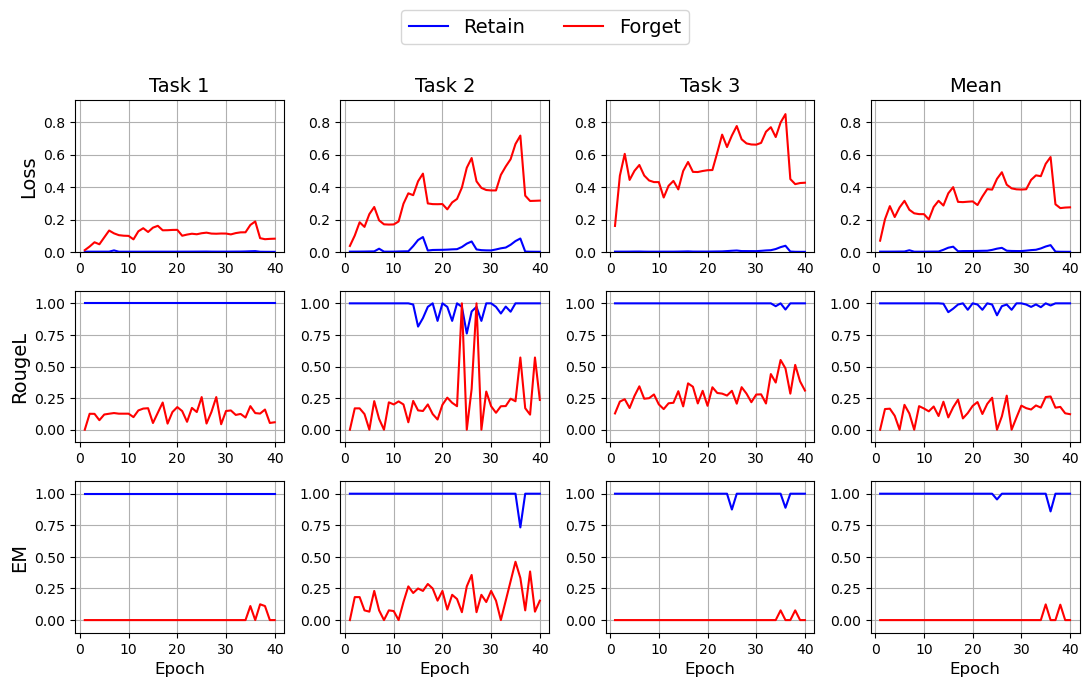

In [17]:
plot_metrics(summary["log_history"], output_dir)

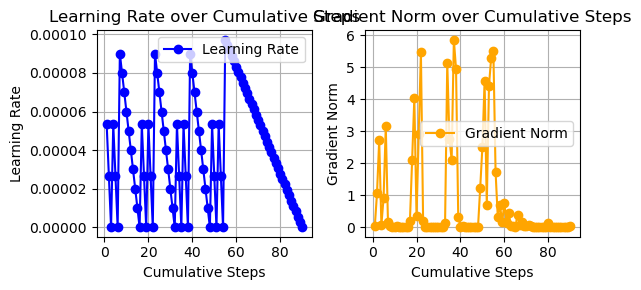

In [18]:
plot_training_stats(summary["log_history"])

In [19]:
peft_model.merge_and_unload()
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OlmoForCausalLM(
      (model): OlmoModel(
        (embed_tokens): Embedding(50304, 4096, padding_idx=1)
        (layers): ModuleList(
          (0-31): 32 x OlmoDecoderLayer(
            (self_attn): OlmoSdpaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): OlmoRotaryEmbedding()
            )
            (mlp): OlmoMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )
           

In [20]:
peft_model.model.save_pretrained("unlearned_model")
trainer.tokenizer.save_pretrained("unlearned_model")

('unlearned_model/tokenizer_config.json',
 'unlearned_model/special_tokens_map.json',
 'unlearned_model/tokenizer.json')

In [21]:
print_gpu_memory()


GPU 0: 3112.25 MB allocated
GPU 0: 3560.00 MB cached

GPU 1: 3490.25 MB allocated
GPU 1: 3958.00 MB cached

GPU 2: 3490.25 MB allocated
GPU 2: 3958.00 MB cached

GPU 3: 3112.25 MB allocated
GPU 3: 3560.00 MB cached


In [22]:
del trainer
del base_model
del peft_model

In [23]:
gc.collect()
torch.cuda.empty_cache()

In [24]:
print_gpu_memory()


GPU 0: 16.25 MB allocated
GPU 0: 220.00 MB cached

GPU 1: 16.25 MB allocated
GPU 1: 220.00 MB cached

GPU 2: 16.25 MB allocated
GPU 2: 220.00 MB cached

GPU 3: 16.25 MB allocated
GPU 3: 220.00 MB cached


## Final Evaluation

In [25]:
evaluation_args = {
    "seed": 42,
    "debug": True,
    "keep_files": True,
    "max_new_tokens": 256,
    "compute_metrics_only": False,
    "batch_size": 8,
    "mia_data_path": "semeval25-unlearning-data/mia_data/",
    "data_path": "semeval25-unlearning-data/data/",
    "checkpoint_path": "unlearned_model",
    "output_dir": f"{output_dir}/evaluation",
    "mmlu_metrics_file_path": None
}

quantitative_eval = QuantitativeEvaluation(evaluation_args)

In [26]:
quantitative_eval.run()

Evaluating Checkpoint at unlearned_model


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 1/278 [00:01<04:52,  1.06s/it]

  1%|          | 2/278 [00:01<02:17,  2.00it/s]

  1%|          | 3/278 [00:02<04:44,  1.04s/it]

  1%|▏         | 4/278 [00:02<03:03,  1.49it/s]

  2%|▏         | 5/278 [00:04<04:29,  1.01it/s]

  2%|▏         | 6/278 [00:04<03:32,  1.28it/s]

  3%|▎         | 7/278 [00:06<04:33,  1.01s/it]

  3%|▎         | 8/278 [00:06<03:21,  1.34it/s]

  3%|▎         | 9/278 [00:08<04:59,  1.11s/it]

  4%|▎         | 10/278 [00:08<03:46,  1.18it/s]

  4%|▍         | 11/278 [00:08<02:53,  1.54it/s]

  4%|▍         | 12/278 [00:09<02:17,  1.94it/s]

  5%|▍         | 13/278 [00:09<02:02,  2.16it/s]

  5%|▌         | 14/278 [00:10<02:08,  2.05it/s]

  5%|▌         | 15/278 [00:11<03:47,  1.15it/s]

  6%|▌         | 16/278 [00:12<03:13,  1.35it/s]

  6%|▌         | 17/278 [00:13<03:53,  1.12it/s]

  6%|▋         | 18/278 [00:13<03:07,  1.39it/s]

  7%|▋         | 19/278 [00:14<03:39,  1.18it/s]

  7%|▋         | 20/278 [00:15<02:52,  1.50it/s]

  8%|▊         | 21/278 [00:15<02:16,  1.89it/s]

  8%|▊         | 22/278 [00:15<01:53,  2.25it/s]

  8%|▊         | 23/278 [00:15<01:48,  2.36it/s]

  9%|▊         | 24/278 [00:16<01:59,  2.12it/s]

  9%|▉         | 25/278 [00:17<03:02,  1.39it/s]

  9%|▉         | 26/278 [00:18<02:22,  1.77it/s]

 10%|▉         | 27/278 [00:19<03:19,  1.26it/s]

 10%|█         | 28/278 [00:19<02:39,  1.57it/s]

 10%|█         | 29/278 [00:21<04:27,  1.07s/it]

 11%|█         | 30/278 [00:22<03:24,  1.21it/s]

 11%|█         | 31/278 [00:22<02:38,  1.56it/s]

 12%|█▏        | 32/278 [00:22<02:08,  1.92it/s]

 12%|█▏        | 33/278 [00:22<01:56,  2.09it/s]

 12%|█▏        | 34/278 [00:23<02:01,  2.01it/s]

 13%|█▎        | 35/278 [00:25<04:17,  1.06s/it]

 13%|█▎        | 36/278 [00:26<03:17,  1.23it/s]

 13%|█▎        | 37/278 [00:28<04:48,  1.20s/it]

 14%|█▎        | 38/278 [00:28<03:38,  1.10it/s]

 14%|█▍        | 39/278 [00:28<02:44,  1.45it/s]

 14%|█▍        | 40/278 [00:28<02:09,  1.83it/s]

 15%|█▍        | 41/278 [00:29<01:57,  2.02it/s]

 15%|█▌        | 42/278 [00:29<02:07,  1.85it/s]

 15%|█▌        | 43/278 [00:31<03:14,  1.21it/s]

 16%|█▌        | 44/278 [00:31<02:30,  1.56it/s]

 16%|█▌        | 45/278 [00:33<03:35,  1.08it/s]

 17%|█▋        | 46/278 [00:33<02:46,  1.39it/s]

 17%|█▋        | 47/278 [00:33<02:10,  1.77it/s]

 17%|█▋        | 48/278 [00:33<01:45,  2.18it/s]

 18%|█▊        | 49/278 [00:34<01:37,  2.36it/s]

 18%|█▊        | 50/278 [00:34<01:45,  2.17it/s]

 18%|█▊        | 51/278 [00:36<02:51,  1.32it/s]

 19%|█▊        | 52/278 [00:36<02:07,  1.78it/s]

 19%|█▉        | 53/278 [00:38<04:10,  1.11s/it]

 19%|█▉        | 54/278 [00:38<03:11,  1.17it/s]

 20%|█▉        | 55/278 [00:38<02:27,  1.51it/s]

 20%|██        | 56/278 [00:39<01:58,  1.87it/s]

 21%|██        | 57/278 [00:39<01:54,  1.93it/s]

 21%|██        | 58/278 [00:40<02:12,  1.66it/s]

 21%|██        | 59/278 [00:41<02:40,  1.36it/s]

 22%|██▏       | 60/278 [00:41<02:08,  1.70it/s]

 22%|██▏       | 61/278 [00:42<01:42,  2.11it/s]

 22%|██▏       | 62/278 [00:42<01:27,  2.47it/s]

 23%|██▎       | 63/278 [00:42<01:29,  2.40it/s]

 23%|██▎       | 64/278 [00:43<01:35,  2.24it/s]

 23%|██▎       | 65/278 [00:44<02:44,  1.29it/s]

 24%|██▎       | 66/278 [00:44<02:03,  1.72it/s]

 24%|██▍       | 67/278 [00:46<02:51,  1.23it/s]

 24%|██▍       | 68/278 [00:46<02:14,  1.56it/s]

 25%|██▍       | 69/278 [00:48<03:14,  1.07it/s]

 25%|██▌       | 70/278 [00:48<02:30,  1.38it/s]

 26%|██▌       | 71/278 [00:48<01:55,  1.79it/s]

 26%|██▌       | 72/278 [00:48<01:35,  2.15it/s]

 26%|██▋       | 73/278 [00:49<01:27,  2.34it/s]

 27%|██▋       | 74/278 [00:49<01:36,  2.11it/s]

 27%|██▋       | 75/278 [00:51<02:47,  1.22it/s]

 27%|██▋       | 76/278 [00:51<02:15,  1.49it/s]

 28%|██▊       | 77/278 [00:53<03:36,  1.08s/it]

 28%|██▊       | 78/278 [00:53<02:41,  1.24it/s]

 28%|██▊       | 79/278 [00:55<03:54,  1.18s/it]

 29%|██▉       | 80/278 [00:56<02:58,  1.11it/s]

 29%|██▉       | 81/278 [00:58<04:49,  1.47s/it]

 29%|██▉       | 82/278 [00:59<03:38,  1.12s/it]

 30%|██▉       | 83/278 [01:01<04:22,  1.35s/it]

 30%|███       | 84/278 [01:01<03:17,  1.02s/it]

 31%|███       | 85/278 [01:01<02:29,  1.29it/s]

 31%|███       | 86/278 [01:01<01:57,  1.63it/s]

 31%|███▏      | 87/278 [01:02<01:41,  1.88it/s]

 32%|███▏      | 88/278 [01:02<01:40,  1.90it/s]

 32%|███▏      | 89/278 [01:04<02:26,  1.29it/s]

 32%|███▏      | 90/278 [01:04<01:53,  1.65it/s]

 33%|███▎      | 91/278 [01:06<03:06,  1.00it/s]

 33%|███▎      | 92/278 [01:06<02:21,  1.31it/s]

 33%|███▎      | 93/278 [01:08<03:15,  1.05s/it]

 34%|███▍      | 94/278 [01:08<02:25,  1.26it/s]

 34%|███▍      | 95/278 [01:09<03:13,  1.06s/it]

 35%|███▍      | 96/278 [01:10<02:25,  1.25it/s]

 35%|███▍      | 97/278 [01:11<03:21,  1.11s/it]

 35%|███▌      | 98/278 [01:12<02:31,  1.19it/s]

 36%|███▌      | 99/278 [01:14<03:46,  1.27s/it]

 36%|███▌      | 100/278 [01:14<02:50,  1.04it/s]

 36%|███▋      | 101/278 [01:14<02:09,  1.36it/s]

 37%|███▋      | 102/278 [01:15<01:43,  1.71it/s]

 37%|███▋      | 103/278 [01:15<01:31,  1.91it/s]

 37%|███▋      | 104/278 [01:16<01:37,  1.78it/s]

 38%|███▊      | 105/278 [01:17<02:41,  1.07it/s]

 38%|███▊      | 106/278 [01:18<02:04,  1.38it/s]

 38%|███▊      | 107/278 [01:18<01:37,  1.76it/s]

 39%|███▉      | 108/278 [01:18<01:20,  2.12it/s]

 39%|███▉      | 109/278 [01:19<01:14,  2.26it/s]

 40%|███▉      | 110/278 [01:19<01:23,  2.02it/s]

 40%|███▉      | 111/278 [01:21<02:18,  1.21it/s]

 40%|████      | 112/278 [01:21<01:44,  1.58it/s]

 41%|████      | 113/278 [01:23<02:33,  1.07it/s]

 41%|████      | 114/278 [01:23<02:03,  1.32it/s]

 41%|████▏     | 115/278 [01:24<02:42,  1.00it/s]

 42%|████▏     | 116/278 [01:25<02:06,  1.28it/s]

 42%|████▏     | 117/278 [01:26<02:33,  1.05it/s]

 42%|████▏     | 118/278 [01:26<01:58,  1.35it/s]

 43%|████▎     | 119/278 [01:28<02:35,  1.02it/s]

 43%|████▎     | 120/278 [01:28<01:59,  1.32it/s]

 44%|████▎     | 121/278 [01:30<02:55,  1.12s/it]

 44%|████▍     | 122/278 [01:30<02:13,  1.17it/s]

 44%|████▍     | 123/278 [01:31<01:42,  1.51it/s]

 45%|████▍     | 124/278 [01:31<01:22,  1.87it/s]

 45%|████▍     | 125/278 [01:31<01:14,  2.05it/s]

 45%|████▌     | 126/278 [01:32<01:16,  1.98it/s]

 46%|████▌     | 127/278 [01:33<02:09,  1.17it/s]

 46%|████▌     | 128/278 [01:33<01:36,  1.56it/s]

 46%|████▋     | 129/278 [01:35<02:05,  1.18it/s]

 47%|████▋     | 130/278 [01:35<01:35,  1.55it/s]

 47%|████▋     | 131/278 [01:37<02:35,  1.06s/it]

 47%|████▋     | 132/278 [01:37<01:59,  1.23it/s]

 48%|████▊     | 133/278 [01:37<01:31,  1.58it/s]

 48%|████▊     | 134/278 [01:38<01:12,  1.98it/s]

 49%|████▊     | 135/278 [01:38<01:08,  2.09it/s]

 49%|████▉     | 136/278 [01:39<01:13,  1.93it/s]

 49%|████▉     | 137/278 [01:41<02:10,  1.08it/s]

 50%|████▉     | 138/278 [01:41<01:40,  1.39it/s]

 50%|█████     | 139/278 [01:42<02:10,  1.07it/s]

 50%|█████     | 140/278 [01:42<01:37,  1.41it/s]

 51%|█████     | 141/278 [01:45<02:50,  1.24s/it]

 51%|█████     | 142/278 [01:45<02:05,  1.08it/s]

 51%|█████▏    | 143/278 [01:47<02:33,  1.14s/it]

 52%|█████▏    | 144/278 [01:47<01:55,  1.16it/s]

 52%|█████▏    | 145/278 [01:48<02:19,  1.05s/it]

 53%|█████▎    | 146/278 [01:49<01:54,  1.15it/s]

 53%|█████▎    | 147/278 [01:51<02:43,  1.24s/it]

 53%|█████▎    | 148/278 [01:51<02:05,  1.03it/s]

 54%|█████▎    | 149/278 [01:53<02:27,  1.15s/it]

 54%|█████▍    | 150/278 [01:53<01:52,  1.14it/s]

 54%|█████▍    | 151/278 [01:55<02:32,  1.20s/it]

 55%|█████▍    | 152/278 [01:55<01:50,  1.14it/s]

 55%|█████▌    | 153/278 [01:57<02:30,  1.20s/it]

 55%|█████▌    | 154/278 [01:57<01:53,  1.09it/s]

 56%|█████▌    | 155/278 [01:58<01:26,  1.42it/s]

 56%|█████▌    | 156/278 [01:58<01:07,  1.81it/s]

 56%|█████▋    | 157/278 [01:58<01:00,  2.00it/s]

 57%|█████▋    | 158/278 [01:59<01:04,  1.87it/s]

 57%|█████▋    | 159/278 [02:01<01:56,  1.02it/s]

 58%|█████▊    | 160/278 [02:01<01:29,  1.31it/s]

 58%|█████▊    | 161/278 [02:01<01:09,  1.68it/s]

 58%|█████▊    | 162/278 [02:02<00:56,  2.04it/s]

 59%|█████▊    | 163/278 [02:02<00:53,  2.14it/s]

 59%|█████▉    | 164/278 [02:02<00:54,  2.08it/s]

 59%|█████▉    | 165/278 [02:04<01:22,  1.37it/s]

 60%|█████▉    | 166/278 [02:04<01:05,  1.71it/s]

 60%|██████    | 167/278 [02:04<00:52,  2.12it/s]

 60%|██████    | 168/278 [02:04<00:44,  2.48it/s]

 61%|██████    | 169/278 [02:05<00:45,  2.40it/s]

 61%|██████    | 170/278 [02:06<00:54,  1.97it/s]

 62%|██████▏   | 171/278 [02:07<01:28,  1.21it/s]

 62%|██████▏   | 172/278 [02:07<01:07,  1.56it/s]

 62%|██████▏   | 173/278 [02:09<01:50,  1.05s/it]

 63%|██████▎   | 174/278 [02:10<01:23,  1.24it/s]

 63%|██████▎   | 175/278 [02:10<01:04,  1.59it/s]

 63%|██████▎   | 176/278 [02:10<00:51,  1.99it/s]

 64%|██████▎   | 177/278 [02:10<00:46,  2.15it/s]

 64%|██████▍   | 178/278 [02:11<00:55,  1.82it/s]

 64%|██████▍   | 179/278 [02:12<01:15,  1.31it/s]

 65%|██████▍   | 180/278 [02:13<00:56,  1.74it/s]

 65%|██████▌   | 181/278 [02:14<01:26,  1.12it/s]

 65%|██████▌   | 182/278 [02:14<01:05,  1.47it/s]

 66%|██████▌   | 183/278 [02:16<01:31,  1.04it/s]

 66%|██████▌   | 184/278 [02:16<01:07,  1.40it/s]

 67%|██████▋   | 185/278 [02:18<01:32,  1.01it/s]

 67%|██████▋   | 186/278 [02:18<01:11,  1.28it/s]

 67%|██████▋   | 187/278 [02:19<01:12,  1.26it/s]

 68%|██████▊   | 188/278 [02:19<00:55,  1.61it/s]

 68%|██████▊   | 189/278 [02:21<01:24,  1.05it/s]

 68%|██████▊   | 190/278 [02:21<01:02,  1.41it/s]

 69%|██████▊   | 191/278 [02:23<01:23,  1.04it/s]

 69%|██████▉   | 192/278 [02:23<01:04,  1.34it/s]

 69%|██████▉   | 193/278 [02:23<00:49,  1.71it/s]

 70%|██████▉   | 194/278 [02:23<00:39,  2.12it/s]

 70%|███████   | 195/278 [02:24<00:37,  2.21it/s]

 71%|███████   | 196/278 [02:24<00:39,  2.08it/s]

 71%|███████   | 197/278 [02:26<01:03,  1.27it/s]

 71%|███████   | 198/278 [02:26<00:50,  1.57it/s]

 72%|███████▏  | 199/278 [02:28<01:30,  1.14s/it]

 72%|███████▏  | 200/278 [02:29<01:12,  1.07it/s]

 72%|███████▏  | 201/278 [02:31<01:35,  1.24s/it]

 73%|███████▎  | 202/278 [02:31<01:11,  1.06it/s]

 73%|███████▎  | 203/278 [02:31<00:54,  1.38it/s]

 73%|███████▎  | 204/278 [02:31<00:42,  1.73it/s]

 74%|███████▎  | 205/278 [02:32<00:37,  1.93it/s]

 74%|███████▍  | 206/278 [02:32<00:37,  1.94it/s]

 74%|███████▍  | 207/278 [02:34<01:07,  1.05it/s]

 75%|███████▍  | 208/278 [02:35<00:51,  1.35it/s]

 75%|███████▌  | 209/278 [02:36<01:03,  1.09it/s]

 76%|███████▌  | 210/278 [02:36<00:48,  1.40it/s]

 76%|███████▌  | 211/278 [02:36<00:37,  1.81it/s]

 76%|███████▋  | 212/278 [02:36<00:29,  2.22it/s]

 77%|███████▋  | 213/278 [02:37<00:28,  2.28it/s]

 77%|███████▋  | 214/278 [02:38<00:31,  2.03it/s]

 77%|███████▋  | 215/278 [02:39<00:49,  1.26it/s]

 78%|███████▊  | 216/278 [02:39<00:37,  1.63it/s]

 78%|███████▊  | 217/278 [02:42<01:08,  1.13s/it]

 78%|███████▊  | 218/278 [02:42<00:49,  1.22it/s]

 79%|███████▉  | 219/278 [02:44<01:13,  1.24s/it]

 79%|███████▉  | 220/278 [02:44<00:53,  1.08it/s]

 79%|███████▉  | 221/278 [02:46<01:02,  1.10s/it]

 80%|███████▉  | 222/278 [02:46<00:46,  1.21it/s]

 80%|████████  | 223/278 [02:48<01:03,  1.15s/it]

 81%|████████  | 224/278 [02:48<00:47,  1.14it/s]

 81%|████████  | 225/278 [02:48<00:35,  1.47it/s]

 81%|████████▏ | 226/278 [02:48<00:27,  1.86it/s]

 82%|████████▏ | 227/278 [02:49<00:24,  2.09it/s]

 82%|████████▏ | 228/278 [02:49<00:25,  1.96it/s]

 82%|████████▏ | 229/278 [02:51<00:48,  1.02it/s]

 83%|████████▎ | 230/278 [02:51<00:35,  1.37it/s]

 83%|████████▎ | 231/278 [02:53<00:44,  1.05it/s]

 83%|████████▎ | 232/278 [02:53<00:34,  1.35it/s]

 84%|████████▍ | 233/278 [02:53<00:25,  1.75it/s]

 84%|████████▍ | 234/278 [02:54<00:20,  2.16it/s]

 85%|████████▍ | 235/278 [02:54<00:18,  2.29it/s]

 85%|████████▍ | 236/278 [02:55<00:20,  2.04it/s]

 85%|████████▌ | 237/278 [02:56<00:37,  1.10it/s]

 86%|████████▌ | 238/278 [02:57<00:28,  1.41it/s]

 86%|████████▌ | 239/278 [02:57<00:21,  1.79it/s]

 86%|████████▋ | 240/278 [02:57<00:17,  2.16it/s]

 87%|████████▋ | 241/278 [02:58<00:16,  2.28it/s]

 87%|████████▋ | 242/278 [02:58<00:16,  2.17it/s]

 87%|████████▋ | 243/278 [03:00<00:31,  1.10it/s]

 88%|████████▊ | 244/278 [03:00<00:24,  1.41it/s]

 88%|████████▊ | 245/278 [03:00<00:18,  1.82it/s]

 88%|████████▊ | 246/278 [03:01<00:14,  2.24it/s]

 89%|████████▉ | 247/278 [03:01<00:13,  2.35it/s]

 89%|████████▉ | 248/278 [03:02<00:14,  2.03it/s]

 90%|████████▉ | 249/278 [03:05<00:35,  1.21s/it]

 90%|████████▉ | 250/278 [03:05<00:24,  1.13it/s]

 90%|█████████ | 251/278 [03:07<00:31,  1.18s/it]

 91%|█████████ | 252/278 [03:07<00:24,  1.05it/s]

 91%|█████████ | 253/278 [03:08<00:24,  1.01it/s]

 91%|█████████▏| 254/278 [03:08<00:18,  1.31it/s]

 92%|█████████▏| 255/278 [03:08<00:13,  1.67it/s]

 92%|█████████▏| 256/278 [03:09<00:10,  2.03it/s]

 92%|█████████▏| 257/278 [03:09<00:09,  2.14it/s]

 93%|█████████▎| 258/278 [03:10<00:09,  2.08it/s]

 93%|█████████▎| 259/278 [03:11<00:13,  1.40it/s]

 94%|█████████▎| 260/278 [03:11<00:11,  1.63it/s]

 94%|█████████▍| 261/278 [03:13<00:18,  1.07s/it]

 94%|█████████▍| 262/278 [03:14<00:12,  1.27it/s]

 95%|█████████▍| 263/278 [03:15<00:16,  1.10s/it]

 95%|█████████▍| 264/278 [03:16<00:11,  1.20it/s]

 95%|█████████▌| 265/278 [03:17<00:13,  1.03s/it]

 96%|█████████▌| 266/278 [03:18<00:11,  1.06it/s]

 96%|█████████▌| 267/278 [03:20<00:13,  1.20s/it]

 96%|█████████▋| 268/278 [03:20<00:10,  1.02s/it]

 97%|█████████▋| 269/278 [03:22<00:11,  1.31s/it]

 97%|█████████▋| 270/278 [03:22<00:07,  1.02it/s]

 97%|█████████▋| 271/278 [03:25<00:10,  1.45s/it]

 98%|█████████▊| 272/278 [03:25<00:06,  1.12s/it]

 98%|█████████▊| 273/278 [03:27<00:05,  1.19s/it]

 99%|█████████▊| 274/278 [03:27<00:03,  1.05it/s]

 99%|█████████▉| 275/278 [03:29<00:03,  1.29s/it]

 99%|█████████▉| 276/278 [03:29<00:01,  1.04it/s]

100%|█████████▉| 277/278 [03:31<00:01,  1.21s/it]

100%|██████████| 278/278 [03:31<00:00,  1.06it/s]

100%|██████████| 278/278 [03:31<00:00,  1.31it/s]

[278, 278, 278, 278, 278, 278]
Saving to:  /opt/ml/output/data/evaluation/retain_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 1/254 [00:01<07:08,  1.69s/it]

  1%|          | 2/254 [00:01<03:16,  1.28it/s]

  1%|          | 3/254 [00:03<04:35,  1.10s/it]

  2%|▏         | 4/254 [00:03<03:24,  1.22it/s]

  2%|▏         | 5/254 [00:05<04:40,  1.12s/it]

  2%|▏         | 6/254 [00:05<03:16,  1.27it/s]

  3%|▎         | 7/254 [00:07<04:43,  1.15s/it]

  3%|▎         | 8/254 [00:07<03:28,  1.18it/s]

  4%|▎         | 9/254 [00:09<04:17,  1.05s/it]

  4%|▍         | 10/254 [00:09<03:10,  1.28it/s]

  4%|▍         | 11/254 [00:10<03:39,  1.11it/s]

  5%|▍         | 12/254 [00:10<02:50,  1.42it/s]

  5%|▌         | 13/254 [00:10<02:13,  1.81it/s]

  6%|▌         | 14/254 [00:11<01:50,  2.18it/s]

  6%|▌         | 15/254 [00:11<01:48,  2.20it/s]

  6%|▋         | 16/254 [00:12<02:02,  1.95it/s]

  7%|▋         | 17/254 [00:13<02:57,  1.34it/s]

  7%|▋         | 18/254 [00:13<02:16,  1.73it/s]

  7%|▋         | 19/254 [00:15<03:53,  1.01it/s]

  8%|▊         | 20/254 [00:15<02:59,  1.30it/s]

  8%|▊         | 21/254 [00:16<02:19,  1.67it/s]

  9%|▊         | 22/254 [00:16<01:52,  2.07it/s]

  9%|▉         | 23/254 [00:16<01:51,  2.07it/s]

  9%|▉         | 24/254 [00:17<01:55,  1.99it/s]

 10%|▉         | 25/254 [00:19<03:12,  1.19it/s]

 10%|█         | 26/254 [00:19<02:33,  1.49it/s]

 11%|█         | 27/254 [00:21<04:18,  1.14s/it]

 11%|█         | 28/254 [00:21<03:18,  1.14it/s]

 11%|█▏        | 29/254 [00:23<04:22,  1.16s/it]

 12%|█▏        | 30/254 [00:23<03:12,  1.17it/s]

 12%|█▏        | 31/254 [00:26<04:52,  1.31s/it]

 13%|█▎        | 32/254 [00:26<03:39,  1.01it/s]

 13%|█▎        | 33/254 [00:26<02:46,  1.32it/s]

 13%|█▎        | 34/254 [00:26<02:09,  1.69it/s]

 14%|█▍        | 35/254 [00:27<01:57,  1.86it/s]

 14%|█▍        | 36/254 [00:27<02:04,  1.75it/s]

 15%|█▍        | 37/254 [00:30<03:51,  1.07s/it]

 15%|█▍        | 38/254 [00:30<02:57,  1.22it/s]

 15%|█▌        | 39/254 [00:30<02:17,  1.57it/s]

 16%|█▌        | 40/254 [00:30<01:48,  1.97it/s]

 16%|█▌        | 41/254 [00:31<01:42,  2.08it/s]

 17%|█▋        | 42/254 [00:31<01:48,  1.96it/s]

 17%|█▋        | 43/254 [00:32<02:25,  1.45it/s]

 17%|█▋        | 44/254 [00:33<01:56,  1.80it/s]

 18%|█▊        | 45/254 [00:33<01:34,  2.21it/s]

 18%|█▊        | 46/254 [00:33<01:20,  2.57it/s]

 19%|█▊        | 47/254 [00:33<01:19,  2.60it/s]

 19%|█▉        | 48/254 [00:34<01:31,  2.25it/s]

 19%|█▉        | 49/254 [00:36<03:11,  1.07it/s]

 20%|█▉        | 50/254 [00:36<02:22,  1.43it/s]

 20%|██        | 51/254 [00:38<03:31,  1.04s/it]

 20%|██        | 52/254 [00:38<02:35,  1.30it/s]

 21%|██        | 53/254 [00:39<02:57,  1.13it/s]

 21%|██▏       | 54/254 [00:40<02:18,  1.45it/s]

 22%|██▏       | 55/254 [00:40<01:48,  1.83it/s]

 22%|██▏       | 56/254 [00:40<01:28,  2.25it/s]

 22%|██▏       | 57/254 [00:40<01:25,  2.30it/s]

 23%|██▎       | 58/254 [00:41<01:35,  2.05it/s]

 23%|██▎       | 59/254 [00:42<02:20,  1.39it/s]

 24%|██▎       | 60/254 [00:42<01:49,  1.77it/s]

 24%|██▍       | 61/254 [00:44<02:48,  1.14it/s]

 24%|██▍       | 62/254 [00:44<02:09,  1.48it/s]

 25%|██▍       | 63/254 [00:46<03:06,  1.03it/s]

 25%|██▌       | 64/254 [00:46<02:27,  1.29it/s]

 26%|██▌       | 65/254 [00:48<03:17,  1.04s/it]

 26%|██▌       | 66/254 [00:48<02:38,  1.18it/s]

 26%|██▋       | 67/254 [00:50<03:30,  1.12s/it]

 27%|██▋       | 68/254 [00:50<02:45,  1.12it/s]

 27%|██▋       | 69/254 [00:52<03:20,  1.08s/it]

 28%|██▊       | 70/254 [00:52<02:34,  1.19it/s]

 28%|██▊       | 71/254 [00:54<03:23,  1.11s/it]

 28%|██▊       | 72/254 [00:54<02:36,  1.16it/s]

 29%|██▊       | 73/254 [00:56<03:07,  1.04s/it]

 29%|██▉       | 74/254 [00:56<02:21,  1.27it/s]

 30%|██▉       | 75/254 [00:58<03:16,  1.10s/it]

 30%|██▉       | 76/254 [00:58<02:29,  1.19it/s]

 30%|███       | 77/254 [00:58<01:55,  1.53it/s]

 31%|███       | 78/254 [00:58<01:31,  1.93it/s]

 31%|███       | 79/254 [00:59<01:21,  2.15it/s]

 31%|███▏      | 80/254 [00:59<01:25,  2.04it/s]

 32%|███▏      | 81/254 [01:01<02:19,  1.24it/s]

 32%|███▏      | 82/254 [01:01<01:49,  1.57it/s]

 33%|███▎      | 83/254 [01:01<01:25,  2.01it/s]

 33%|███▎      | 84/254 [01:01<01:09,  2.43it/s]

 33%|███▎      | 85/254 [01:02<01:05,  2.56it/s]

 34%|███▍      | 86/254 [01:02<01:16,  2.18it/s]

 34%|███▍      | 87/254 [01:03<01:42,  1.62it/s]

 35%|███▍      | 88/254 [01:04<01:23,  1.99it/s]

 35%|███▌      | 89/254 [01:05<02:21,  1.16it/s]

 35%|███▌      | 90/254 [01:06<01:50,  1.48it/s]

 36%|███▌      | 91/254 [01:06<01:27,  1.87it/s]

 36%|███▌      | 92/254 [01:06<01:10,  2.29it/s]

 37%|███▋      | 93/254 [01:06<01:05,  2.45it/s]

 37%|███▋      | 94/254 [01:07<01:15,  2.13it/s]

 37%|███▋      | 95/254 [01:09<02:49,  1.07s/it]

 38%|███▊      | 96/254 [01:10<02:08,  1.23it/s]

 38%|███▊      | 97/254 [01:12<03:03,  1.17s/it]

 39%|███▊      | 98/254 [01:12<02:15,  1.15it/s]

 39%|███▉      | 99/254 [01:13<02:34,  1.00it/s]

 39%|███▉      | 100/254 [01:13<01:53,  1.35it/s]

 40%|███▉      | 101/254 [01:15<02:43,  1.07s/it]

 40%|████      | 102/254 [01:15<02:01,  1.25it/s]

 41%|████      | 103/254 [01:18<03:09,  1.25s/it]

 41%|████      | 104/254 [01:18<02:17,  1.09it/s]

 41%|████▏     | 105/254 [01:19<02:37,  1.06s/it]

 42%|████▏     | 106/254 [01:19<02:00,  1.23it/s]

 42%|████▏     | 107/254 [01:20<01:32,  1.59it/s]

 43%|████▎     | 108/254 [01:20<01:13,  1.98it/s]

 43%|████▎     | 109/254 [01:20<01:06,  2.19it/s]

 43%|████▎     | 110/254 [01:21<01:08,  2.11it/s]

 44%|████▎     | 111/254 [01:23<02:17,  1.04it/s]

 44%|████▍     | 112/254 [01:23<01:45,  1.34it/s]

 44%|████▍     | 113/254 [01:23<01:22,  1.71it/s]

 45%|████▍     | 114/254 [01:23<01:06,  2.12it/s]

 45%|████▌     | 115/254 [01:24<01:04,  2.16it/s]

 46%|████▌     | 116/254 [01:24<01:08,  2.00it/s]

 46%|████▌     | 117/254 [01:26<02:08,  1.07it/s]

 46%|████▋     | 118/254 [01:27<01:39,  1.37it/s]

 47%|████▋     | 119/254 [01:27<01:17,  1.75it/s]

 47%|████▋     | 120/254 [01:27<01:01,  2.16it/s]

 48%|████▊     | 121/254 [01:27<00:58,  2.29it/s]

 48%|████▊     | 122/254 [01:28<00:59,  2.22it/s]

 48%|████▊     | 123/254 [01:30<02:08,  1.02it/s]

 49%|████▉     | 124/254 [01:31<01:54,  1.13it/s]

 49%|████▉     | 125/254 [01:32<02:20,  1.09s/it]

 50%|████▉     | 126/254 [01:32<01:44,  1.23it/s]

 50%|█████     | 127/254 [01:34<02:09,  1.02s/it]

 50%|█████     | 128/254 [01:34<01:34,  1.34it/s]

 51%|█████     | 129/254 [01:36<02:22,  1.14s/it]

 51%|█████     | 130/254 [01:36<01:45,  1.18it/s]

 52%|█████▏    | 131/254 [01:38<02:17,  1.12s/it]

 52%|█████▏    | 132/254 [01:38<01:44,  1.17it/s]

 52%|█████▏    | 133/254 [01:38<01:18,  1.53it/s]

 53%|█████▎    | 134/254 [01:39<01:02,  1.93it/s]

 53%|█████▎    | 135/254 [01:39<00:57,  2.05it/s]

 54%|█████▎    | 136/254 [01:40<01:06,  1.77it/s]

 54%|█████▍    | 137/254 [01:41<01:14,  1.57it/s]

 54%|█████▍    | 138/254 [01:41<00:56,  2.05it/s]

 55%|█████▍    | 139/254 [01:42<01:25,  1.34it/s]

 55%|█████▌    | 140/254 [01:42<01:03,  1.80it/s]

 56%|█████▌    | 141/254 [01:44<01:51,  1.02it/s]

 56%|█████▌    | 142/254 [01:44<01:25,  1.31it/s]

 56%|█████▋    | 143/254 [01:45<01:05,  1.71it/s]

 57%|█████▋    | 144/254 [01:45<00:53,  2.07it/s]

 57%|█████▋    | 145/254 [01:45<00:50,  2.17it/s]

 57%|█████▋    | 146/254 [01:46<00:53,  2.01it/s]

 58%|█████▊    | 147/254 [01:47<01:16,  1.40it/s]

 58%|█████▊    | 148/254 [01:47<00:59,  1.78it/s]

 59%|█████▊    | 149/254 [01:49<01:34,  1.11it/s]

 59%|█████▉    | 150/254 [01:49<01:10,  1.47it/s]

 59%|█████▉    | 151/254 [01:51<01:45,  1.02s/it]

 60%|█████▉    | 152/254 [01:51<01:18,  1.30it/s]

 60%|██████    | 153/254 [01:53<01:48,  1.08s/it]

 61%|██████    | 154/254 [01:53<01:22,  1.21it/s]

 61%|██████    | 155/254 [01:55<01:44,  1.06s/it]

 61%|██████▏   | 156/254 [01:55<01:15,  1.29it/s]

 62%|██████▏   | 157/254 [01:56<01:32,  1.05it/s]

 62%|██████▏   | 158/254 [01:56<01:09,  1.39it/s]

 63%|██████▎   | 159/254 [01:58<01:35,  1.01s/it]

 63%|██████▎   | 160/254 [01:58<01:14,  1.26it/s]

 63%|██████▎   | 161/254 [02:01<02:06,  1.36s/it]

 64%|██████▍   | 162/254 [02:01<01:31,  1.00it/s]

 64%|██████▍   | 163/254 [02:02<01:29,  1.02it/s]

 65%|██████▍   | 164/254 [02:03<01:11,  1.26it/s]

 65%|██████▍   | 165/254 [02:04<01:27,  1.02it/s]

 65%|██████▌   | 166/254 [02:04<01:04,  1.37it/s]

 66%|██████▌   | 167/254 [02:05<01:14,  1.17it/s]

 66%|██████▌   | 168/254 [02:06<00:57,  1.49it/s]

 67%|██████▋   | 169/254 [02:06<00:44,  1.92it/s]

 67%|██████▋   | 170/254 [02:06<00:35,  2.34it/s]

 67%|██████▋   | 171/254 [02:06<00:35,  2.37it/s]

 68%|██████▊   | 172/254 [02:07<00:37,  2.17it/s]

 68%|██████▊   | 173/254 [02:09<01:17,  1.04it/s]

 69%|██████▊   | 174/254 [02:09<00:59,  1.34it/s]

 69%|██████▉   | 175/254 [02:09<00:46,  1.71it/s]

 69%|██████▉   | 176/254 [02:10<00:36,  2.12it/s]

 70%|██████▉   | 177/254 [02:10<00:34,  2.21it/s]

 70%|███████   | 178/254 [02:11<00:37,  2.03it/s]

 70%|███████   | 179/254 [02:12<01:03,  1.19it/s]

 71%|███████   | 180/254 [02:12<00:46,  1.61it/s]

 71%|███████▏  | 181/254 [02:14<01:11,  1.03it/s]

 72%|███████▏  | 182/254 [02:14<00:52,  1.38it/s]

 72%|███████▏  | 183/254 [02:15<01:00,  1.17it/s]

 72%|███████▏  | 184/254 [02:16<00:46,  1.49it/s]

 73%|███████▎  | 185/254 [02:16<00:36,  1.88it/s]

 73%|███████▎  | 186/254 [02:16<00:29,  2.30it/s]

 74%|███████▎  | 187/254 [02:17<00:28,  2.34it/s]

 74%|███████▍  | 188/254 [02:17<00:32,  2.02it/s]

 74%|███████▍  | 189/254 [02:19<00:59,  1.10it/s]

 75%|███████▍  | 190/254 [02:19<00:45,  1.41it/s]

 75%|███████▌  | 191/254 [02:20<00:35,  1.79it/s]

 76%|███████▌  | 192/254 [02:20<00:28,  2.15it/s]

 76%|███████▌  | 193/254 [02:20<00:26,  2.28it/s]

 76%|███████▋  | 194/254 [02:21<00:30,  1.99it/s]

 77%|███████▋  | 195/254 [02:23<00:52,  1.13it/s]

 77%|███████▋  | 196/254 [02:23<00:38,  1.49it/s]

 78%|███████▊  | 197/254 [02:25<01:00,  1.06s/it]

 78%|███████▊  | 198/254 [02:25<00:45,  1.23it/s]

 78%|███████▊  | 199/254 [02:25<00:34,  1.61it/s]

 79%|███████▊  | 200/254 [02:25<00:27,  1.97it/s]

 79%|███████▉  | 201/254 [02:26<00:24,  2.14it/s]

 80%|███████▉  | 202/254 [02:26<00:25,  2.03it/s]

 80%|███████▉  | 203/254 [02:28<00:41,  1.23it/s]

 80%|████████  | 204/254 [02:28<00:32,  1.56it/s]

 81%|████████  | 205/254 [02:28<00:25,  1.96it/s]

 81%|████████  | 206/254 [02:29<00:20,  2.32it/s]

 81%|████████▏ | 207/254 [02:29<00:20,  2.30it/s]

 82%|████████▏ | 208/254 [02:30<00:21,  2.13it/s]

 82%|████████▏ | 209/254 [02:31<00:38,  1.15it/s]

 83%|████████▎ | 210/254 [02:32<00:29,  1.47it/s]

 83%|████████▎ | 211/254 [02:32<00:22,  1.89it/s]

 83%|████████▎ | 212/254 [02:32<00:18,  2.31it/s]

 84%|████████▍ | 213/254 [02:32<00:17,  2.35it/s]

 84%|████████▍ | 214/254 [02:33<00:18,  2.21it/s]

 85%|████████▍ | 215/254 [02:34<00:29,  1.31it/s]

 85%|████████▌ | 216/254 [02:35<00:24,  1.54it/s]

 85%|████████▌ | 217/254 [02:36<00:34,  1.06it/s]

 86%|████████▌ | 218/254 [02:37<00:24,  1.44it/s]

 86%|████████▌ | 219/254 [02:38<00:31,  1.12it/s]

 87%|████████▋ | 220/254 [02:38<00:22,  1.52it/s]

 87%|████████▋ | 221/254 [02:39<00:30,  1.09it/s]

 87%|████████▋ | 222/254 [02:40<00:22,  1.40it/s]

 88%|████████▊ | 223/254 [02:40<00:17,  1.78it/s]

 88%|████████▊ | 224/254 [02:40<00:14,  2.14it/s]

 89%|████████▊ | 225/254 [02:41<00:13,  2.22it/s]

 89%|████████▉ | 226/254 [02:41<00:13,  2.04it/s]

 89%|████████▉ | 227/254 [02:42<00:17,  1.52it/s]

 90%|████████▉ | 228/254 [02:42<00:12,  2.03it/s]

 90%|█████████ | 229/254 [02:43<00:16,  1.47it/s]

 91%|█████████ | 230/254 [02:44<00:12,  1.86it/s]

 91%|█████████ | 231/254 [02:45<00:19,  1.18it/s]

 91%|█████████▏| 232/254 [02:46<00:15,  1.44it/s]

 92%|█████████▏| 233/254 [02:47<00:19,  1.10it/s]

 92%|█████████▏| 234/254 [02:48<00:16,  1.25it/s]

 93%|█████████▎| 235/254 [02:49<00:18,  1.02it/s]

 93%|█████████▎| 236/254 [02:49<00:12,  1.39it/s]

 93%|█████████▎| 237/254 [02:51<00:19,  1.14s/it]

 94%|█████████▎| 238/254 [02:51<00:13,  1.15it/s]

 94%|█████████▍| 239/254 [02:53<00:16,  1.11s/it]

 94%|█████████▍| 240/254 [02:53<00:12,  1.16it/s]

 95%|█████████▍| 241/254 [02:57<00:23,  1.83s/it]

 95%|█████████▌| 242/254 [02:58<00:15,  1.32s/it]

 96%|█████████▌| 243/254 [02:59<00:15,  1.43s/it]

 96%|█████████▌| 244/254 [02:59<00:10,  1.05s/it]

 96%|█████████▋| 245/254 [03:01<00:11,  1.26s/it]

 97%|█████████▋| 246/254 [03:01<00:07,  1.04it/s]

 97%|█████████▋| 247/254 [03:02<00:05,  1.36it/s]

 98%|█████████▊| 248/254 [03:02<00:03,  1.74it/s]

 98%|█████████▊| 249/254 [03:02<00:02,  1.90it/s]

 98%|█████████▊| 250/254 [03:03<00:02,  1.88it/s]

 99%|█████████▉| 251/254 [03:05<00:02,  1.13it/s]

 99%|█████████▉| 252/254 [03:05<00:01,  1.34it/s]

100%|█████████▉| 253/254 [03:07<00:01,  1.01s/it]

100%|██████████| 254/254 [03:07<00:00,  1.33it/s]

100%|██████████| 254/254 [03:07<00:00,  1.36it/s]

[254, 254, 254, 254, 254, 254]
Saving to:  /opt/ml/output/data/evaluation/forget_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  1%|          | 2/250 [00:00<00:22, 10.95it/s]

  2%|▏         | 4/250 [00:00<00:24,  9.96it/s]

  2%|▏         | 6/250 [00:00<00:26,  9.35it/s]

  3%|▎         | 7/250 [00:00<00:27,  8.99it/s]

  4%|▎         | 9/250 [00:00<00:21, 11.14it/s]

  4%|▍         | 11/250 [00:01<00:23, 10.38it/s]

  5%|▌         | 13/250 [00:01<00:23,  9.99it/s]

  6%|▌         | 15/250 [00:01<00:22, 10.32it/s]

  7%|▋         | 17/250 [00:01<00:23,  9.95it/s]

  8%|▊         | 19/250 [00:01<00:20, 11.46it/s]

  8%|▊         | 21/250 [00:02<00:21, 10.71it/s]

  9%|▉         | 23/250 [00:02<00:22, 10.01it/s]

 10%|█         | 25/250 [00:02<00:22, 10.10it/s]

 11%|█         | 27/250 [00:02<00:21, 10.31it/s]

 12%|█▏        | 29/250 [00:02<00:19, 11.09it/s]

 12%|█▏        | 31/250 [00:02<00:18, 11.69it/s]

 13%|█▎        | 33/250 [00:03<00:17, 12.16it/s]

 14%|█▍        | 35/250 [00:03<00:17, 12.03it/s]

 15%|█▍        | 37/250 [00:03<00:19, 11.03it/s]

 16%|█▌        | 39/250 [00:03<00:19, 11.05it/s]

 16%|█▋        | 41/250 [00:03<00:18, 11.02it/s]

 17%|█▋        | 43/250 [00:03<00:17, 11.64it/s]

 18%|█▊        | 45/250 [00:04<00:15, 12.82it/s]

 19%|█▉        | 47/250 [00:04<00:16, 12.18it/s]

 20%|█▉        | 49/250 [00:04<00:17, 11.82it/s]

 20%|██        | 51/250 [00:04<00:18, 10.94it/s]

 21%|██        | 53/250 [00:04<00:19, 10.36it/s]

 22%|██▏       | 55/250 [00:05<00:18, 10.50it/s]

 23%|██▎       | 57/250 [00:05<00:18, 10.39it/s]

 24%|██▎       | 59/250 [00:05<00:19, 10.04it/s]

 24%|██▍       | 61/250 [00:05<00:18, 10.31it/s]

 25%|██▌       | 63/250 [00:05<00:17, 10.49it/s]

 26%|██▌       | 65/250 [00:06<00:17, 10.41it/s]

 27%|██▋       | 67/250 [00:06<00:15, 11.76it/s]

 28%|██▊       | 69/250 [00:06<00:16, 10.88it/s]

 28%|██▊       | 71/250 [00:06<00:15, 11.76it/s]

 29%|██▉       | 73/250 [00:06<00:14, 12.19it/s]

 30%|███       | 75/250 [00:06<00:16, 10.88it/s]

 31%|███       | 77/250 [00:07<00:15, 11.25it/s]

 32%|███▏      | 79/250 [00:07<00:16, 10.62it/s]

 32%|███▏      | 81/250 [00:07<00:16, 10.18it/s]

 33%|███▎      | 83/250 [00:07<00:15, 10.95it/s]

 34%|███▍      | 85/250 [00:07<00:14, 11.57it/s]

 35%|███▍      | 87/250 [00:08<00:15, 10.76it/s]

 36%|███▌      | 89/250 [00:08<00:15, 10.27it/s]

 36%|███▋      | 91/250 [00:08<00:14, 10.71it/s]

 37%|███▋      | 93/250 [00:08<00:15, 10.24it/s]

 38%|███▊      | 95/250 [00:08<00:15,  9.97it/s]

 39%|███▉      | 97/250 [00:08<00:14, 10.80it/s]

 40%|███▉      | 99/250 [00:09<00:15,  9.79it/s]

 40%|████      | 101/250 [00:09<00:14, 10.63it/s]

 41%|████      | 103/250 [00:09<00:13, 10.81it/s]

 42%|████▏     | 105/250 [00:09<00:14, 10.34it/s]

 43%|████▎     | 107/250 [00:09<00:12, 11.31it/s]

 44%|████▎     | 109/250 [00:10<00:14, 10.07it/s]

 44%|████▍     | 111/250 [00:10<00:14,  9.81it/s]

 45%|████▌     | 113/250 [00:10<00:12, 10.86it/s]

 46%|████▌     | 115/250 [00:10<00:11, 11.34it/s]

 47%|████▋     | 117/250 [00:10<00:10, 12.14it/s]

 48%|████▊     | 119/250 [00:10<00:10, 12.44it/s]

 48%|████▊     | 121/250 [00:11<00:11, 11.34it/s]

 49%|████▉     | 123/250 [00:11<00:11, 11.25it/s]

 50%|█████     | 125/250 [00:11<00:11, 11.20it/s]

 51%|█████     | 127/250 [00:11<00:11, 11.17it/s]

 52%|█████▏    | 129/250 [00:11<00:10, 11.71it/s]

 52%|█████▏    | 131/250 [00:12<00:10, 11.77it/s]

 53%|█████▎    | 133/250 [00:12<00:09, 12.25it/s]

 54%|█████▍    | 135/250 [00:12<00:09, 12.57it/s]

 55%|█████▍    | 137/250 [00:12<00:09, 12.05it/s]

 56%|█████▌    | 139/250 [00:12<00:08, 13.23it/s]

 56%|█████▋    | 141/250 [00:12<00:08, 12.49it/s]

 57%|█████▋    | 143/250 [00:12<00:08, 12.00it/s]

 58%|█████▊    | 145/250 [00:13<00:09, 11.64it/s]

 59%|█████▉    | 147/250 [00:13<00:09, 11.19it/s]

 60%|█████▉    | 149/250 [00:13<00:08, 12.45it/s]

 60%|██████    | 151/250 [00:13<00:07, 12.76it/s]

 61%|██████    | 153/250 [00:13<00:08, 11.86it/s]

 62%|██████▏   | 155/250 [00:14<00:09, 10.39it/s]

 63%|██████▎   | 157/250 [00:14<00:08, 10.53it/s]

 64%|██████▎   | 159/250 [00:14<00:08, 10.67it/s]

 64%|██████▍   | 161/250 [00:14<00:08, 10.83it/s]

 65%|██████▌   | 163/250 [00:14<00:07, 11.20it/s]

 66%|██████▌   | 165/250 [00:14<00:07, 12.03it/s]

 67%|██████▋   | 167/250 [00:15<00:06, 11.99it/s]

 68%|██████▊   | 169/250 [00:15<00:07, 11.01it/s]

 68%|██████▊   | 171/250 [00:15<00:06, 11.65it/s]

 69%|██████▉   | 173/250 [00:15<00:06, 12.39it/s]

 70%|███████   | 175/250 [00:15<00:05, 12.71it/s]

 71%|███████   | 177/250 [00:15<00:05, 12.45it/s]

 72%|███████▏  | 179/250 [00:16<00:06, 11.28it/s]

 72%|███████▏  | 181/250 [00:16<00:06, 10.78it/s]

 73%|███████▎  | 183/250 [00:16<00:06, 10.32it/s]

 74%|███████▍  | 185/250 [00:16<00:06, 10.83it/s]

 75%|███████▍  | 187/250 [00:16<00:05, 10.92it/s]

 76%|███████▌  | 189/250 [00:17<00:05, 11.58it/s]

 76%|███████▋  | 191/250 [00:17<00:04, 12.31it/s]

 77%|███████▋  | 193/250 [00:17<00:05, 11.23it/s]

 78%|███████▊  | 195/250 [00:17<00:05, 10.35it/s]

 79%|███████▉  | 197/250 [00:17<00:05, 10.56it/s]

 80%|███████▉  | 199/250 [00:17<00:04, 10.93it/s]

 80%|████████  | 201/250 [00:18<00:04, 10.73it/s]

 81%|████████  | 203/250 [00:18<00:04, 10.79it/s]

 82%|████████▏ | 205/250 [00:18<00:04, 10.85it/s]

 83%|████████▎ | 207/250 [00:18<00:03, 11.50it/s]

 84%|████████▎ | 209/250 [00:18<00:03, 10.94it/s]

 84%|████████▍ | 211/250 [00:19<00:03, 11.28it/s]

 85%|████████▌ | 213/250 [00:19<00:03, 11.19it/s]

 86%|████████▌ | 215/250 [00:19<00:03, 10.58it/s]

 87%|████████▋ | 217/250 [00:19<00:03, 10.89it/s]

 88%|████████▊ | 219/250 [00:19<00:02, 10.94it/s]

 88%|████████▊ | 221/250 [00:19<00:02, 10.71it/s]

 89%|████████▉ | 223/250 [00:20<00:02, 12.07it/s]

 90%|█████████ | 225/250 [00:20<00:02, 11.78it/s]

 91%|█████████ | 227/250 [00:20<00:01, 12.24it/s]

 92%|█████████▏| 229/250 [00:20<00:01, 11.19it/s]

 92%|█████████▏| 231/250 [00:20<00:01, 11.48it/s]

 93%|█████████▎| 233/250 [00:21<00:01, 10.71it/s]

 94%|█████████▍| 235/250 [00:21<00:01, 10.76it/s]

 95%|█████████▍| 237/250 [00:21<00:01, 10.28it/s]

 96%|█████████▌| 239/250 [00:21<00:01, 10.55it/s]

 96%|█████████▋| 241/250 [00:21<00:00,  9.92it/s]

 97%|█████████▋| 243/250 [00:21<00:00, 10.76it/s]

 98%|█████████▊| 245/250 [00:22<00:00, 12.08it/s]

 99%|█████████▉| 247/250 [00:22<00:00, 11.09it/s]

100%|█████████▉| 249/250 [00:22<00:00, 10.23it/s]

100%|██████████| 250/250 [00:22<00:00, 11.04it/s]

Saving to:  /opt/ml/output/data/evaluation/mia_results/member_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  1%|          | 2/250 [00:00<00:18, 13.41it/s]

  2%|▏         | 4/250 [00:00<00:20, 11.76it/s]

  2%|▏         | 6/250 [00:00<00:21, 11.34it/s]

  3%|▎         | 8/250 [00:00<00:21, 11.19it/s]

  4%|▍         | 10/250 [00:00<00:20, 11.89it/s]

  5%|▍         | 12/250 [00:00<00:18, 12.66it/s]

  6%|▌         | 14/250 [00:01<00:20, 11.32it/s]

  6%|▋         | 16/250 [00:01<00:22, 10.58it/s]

  7%|▋         | 18/250 [00:01<00:22, 10.15it/s]

  8%|▊         | 20/250 [00:01<00:21, 10.63it/s]

  9%|▉         | 22/250 [00:01<00:21, 10.54it/s]

 10%|▉         | 24/250 [00:02<00:22, 10.09it/s]

 10%|█         | 26/250 [00:02<00:20, 10.92it/s]

 11%|█         | 28/250 [00:02<00:21, 10.39it/s]

 12%|█▏        | 30/250 [00:02<00:19, 11.12it/s]

 13%|█▎        | 32/250 [00:02<00:20, 10.83it/s]

 14%|█▎        | 34/250 [00:03<00:21, 10.06it/s]

 14%|█▍        | 36/250 [00:03<00:21,  9.80it/s]

 15%|█▌        | 38/250 [00:03<00:23,  9.16it/s]

 16%|█▌        | 40/250 [00:03<00:19, 10.63it/s]

 17%|█▋        | 42/250 [00:03<00:20, 10.18it/s]

 18%|█▊        | 44/250 [00:04<00:19, 10.40it/s]

 18%|█▊        | 46/250 [00:04<00:19, 10.63it/s]

 19%|█▉        | 48/250 [00:04<00:18, 10.72it/s]

 20%|██        | 50/250 [00:04<00:17, 11.64it/s]

 21%|██        | 52/250 [00:04<00:17, 11.42it/s]

 22%|██▏       | 54/250 [00:04<00:17, 11.30it/s]

 22%|██▏       | 56/250 [00:05<00:18, 10.59it/s]

 23%|██▎       | 58/250 [00:05<00:18, 10.45it/s]

 24%|██▍       | 60/250 [00:05<00:18, 10.07it/s]

 25%|██▍       | 62/250 [00:05<00:19,  9.61it/s]

 25%|██▌       | 63/250 [00:05<00:20,  9.29it/s]

 26%|██▌       | 65/250 [00:06<00:18,  9.79it/s]

 27%|██▋       | 67/250 [00:06<00:17, 10.20it/s]

 28%|██▊       | 69/250 [00:06<00:16, 10.88it/s]

 28%|██▊       | 71/250 [00:06<00:17, 10.35it/s]

 29%|██▉       | 73/250 [00:06<00:15, 11.13it/s]

 30%|███       | 75/250 [00:07<00:16, 10.50it/s]

 31%|███       | 77/250 [00:07<00:15, 11.25it/s]

 32%|███▏      | 79/250 [00:07<00:15, 11.14it/s]

 32%|███▏      | 81/250 [00:07<00:16, 10.46it/s]

 33%|███▎      | 83/250 [00:07<00:15, 10.65it/s]

 34%|███▍      | 85/250 [00:08<00:15, 10.55it/s]

 35%|███▍      | 87/250 [00:08<00:15, 10.64it/s]

 36%|███▌      | 89/250 [00:08<00:14, 10.76it/s]

 36%|███▋      | 91/250 [00:08<00:15, 10.28it/s]

 37%|███▋      | 93/250 [00:08<00:14, 10.49it/s]

 38%|███▊      | 95/250 [00:08<00:14, 10.70it/s]

 39%|███▉      | 97/250 [00:09<00:14, 10.80it/s]

 40%|███▉      | 99/250 [00:09<00:12, 12.10it/s]

 40%|████      | 101/250 [00:09<00:13, 11.11it/s]

 41%|████      | 103/250 [00:09<00:11, 12.38it/s]

 42%|████▏     | 105/250 [00:09<00:13, 10.62it/s]

 43%|████▎     | 107/250 [00:10<00:14,  9.68it/s]

 44%|████▎     | 109/250 [00:10<00:13, 10.23it/s]

 44%|████▍     | 111/250 [00:10<00:13, 10.43it/s]

 45%|████▌     | 113/250 [00:10<00:13, 10.06it/s]

 46%|████▌     | 115/250 [00:10<00:13,  9.99it/s]

 47%|████▋     | 117/250 [00:11<00:13,  9.79it/s]

 48%|████▊     | 119/250 [00:11<00:11, 11.18it/s]

 48%|████▊     | 121/250 [00:11<00:11, 11.37it/s]

 49%|████▉     | 123/250 [00:11<00:10, 11.91it/s]

 50%|█████     | 125/250 [00:11<00:11, 10.73it/s]

 51%|█████     | 127/250 [00:11<00:11, 10.78it/s]

 52%|█████▏    | 129/250 [00:12<00:11, 10.83it/s]

 52%|█████▏    | 131/250 [00:12<00:10, 11.32it/s]

 53%|█████▎    | 133/250 [00:12<00:10, 11.19it/s]

 54%|█████▍    | 135/250 [00:12<00:11, 10.02it/s]

 55%|█████▍    | 137/250 [00:12<00:12,  9.32it/s]

 56%|█████▌    | 139/250 [00:13<00:10, 10.82it/s]

 56%|█████▋    | 141/250 [00:13<00:09, 11.46it/s]

 57%|█████▋    | 143/250 [00:13<00:09, 11.09it/s]

 58%|█████▊    | 145/250 [00:13<00:08, 11.69it/s]

 59%|█████▉    | 147/250 [00:13<00:08, 11.52it/s]

 60%|█████▉    | 149/250 [00:13<00:08, 11.34it/s]

 60%|██████    | 151/250 [00:14<00:09, 10.99it/s]

 61%|██████    | 153/250 [00:14<00:09, 10.75it/s]

 62%|██████▏   | 155/250 [00:14<00:09, 10.26it/s]

 63%|██████▎   | 157/250 [00:14<00:08, 10.70it/s]

 64%|██████▎   | 159/250 [00:14<00:08, 11.02it/s]

 64%|██████▍   | 161/250 [00:14<00:07, 12.33it/s]

 65%|██████▌   | 163/250 [00:15<00:07, 12.28it/s]

 66%|██████▌   | 165/250 [00:15<00:07, 11.92it/s]

 67%|██████▋   | 167/250 [00:15<00:07, 11.66it/s]

 68%|██████▊   | 169/250 [00:15<00:06, 12.37it/s]

 68%|██████▊   | 171/250 [00:15<00:07, 11.24it/s]

 69%|██████▉   | 173/250 [00:16<00:07, 10.56it/s]

 70%|███████   | 175/250 [00:16<00:06, 11.26it/s]

 71%|███████   | 177/250 [00:16<00:06, 10.56it/s]

 72%|███████▏  | 179/250 [00:16<00:06, 10.67it/s]

 72%|███████▏  | 181/250 [00:16<00:06, 10.17it/s]

 73%|███████▎  | 183/250 [00:17<00:06, 10.43it/s]

 74%|███████▍  | 185/250 [00:17<00:05, 11.17it/s]

 75%|███████▍  | 187/250 [00:17<00:05, 11.12it/s]

 76%|███████▌  | 189/250 [00:17<00:05, 11.09it/s]

 76%|███████▋  | 191/250 [00:17<00:04, 12.41it/s]

 77%|███████▋  | 193/250 [00:17<00:04, 12.74it/s]

 78%|███████▊  | 195/250 [00:18<00:04, 11.37it/s]

 79%|███████▉  | 197/250 [00:18<00:04, 10.69it/s]

 80%|███████▉  | 199/250 [00:18<00:04, 10.81it/s]

 80%|████████  | 201/250 [00:18<00:04, 11.49it/s]

 81%|████████  | 203/250 [00:18<00:04, 11.33it/s]

 82%|████████▏ | 205/250 [00:18<00:03, 11.50it/s]

 83%|████████▎ | 207/250 [00:19<00:03, 11.98it/s]

 84%|████████▎ | 209/250 [00:19<00:03, 11.25it/s]

 84%|████████▍ | 211/250 [00:19<00:03, 11.16it/s]

 85%|████████▌ | 213/250 [00:19<00:03, 10.54it/s]

 86%|████████▌ | 215/250 [00:19<00:03, 11.22it/s]

 87%|████████▋ | 217/250 [00:20<00:03, 10.75it/s]

 88%|████████▊ | 219/250 [00:20<00:02, 10.85it/s]

 88%|████████▊ | 221/250 [00:20<00:02, 10.94it/s]

 89%|████████▉ | 223/250 [00:20<00:02, 10.43it/s]

 90%|█████████ | 225/250 [00:20<00:02, 10.25it/s]

 91%|█████████ | 227/250 [00:21<00:02,  9.47it/s]

 91%|█████████ | 228/250 [00:21<00:02,  9.19it/s]

 92%|█████████▏| 230/250 [00:21<00:02,  9.75it/s]

 93%|█████████▎| 232/250 [00:21<00:01, 10.14it/s]

 94%|█████████▎| 234/250 [00:21<00:01,  9.88it/s]

 94%|█████████▍| 236/250 [00:21<00:01, 10.26it/s]

 95%|█████████▌| 238/250 [00:22<00:01, 11.08it/s]

 96%|█████████▌| 240/250 [00:22<00:00, 10.79it/s]

 97%|█████████▋| 242/250 [00:22<00:00, 10.83it/s]

 98%|█████████▊| 244/250 [00:22<00:00, 10.26it/s]

 98%|█████████▊| 246/250 [00:22<00:00,  9.95it/s]

 99%|█████████▉| 248/250 [00:23<00:00, 10.01it/s]

100%|██████████| 250/250 [00:23<00:00, 10.29it/s]

100%|██████████| 250/250 [00:23<00:00, 10.75it/s]

Saving to:  /opt/ml/output/data/evaluation/mia_results/nonmember_0.csv


In [27]:
torch.cuda.empty_cache()

In [28]:
qualitative_eval = QualitativeEvaluation(
    checkpoint_path="unlearned_model",
    path_to_predictions=f'{output_dir}/evaluation',
    path_to_gqa='general_questions.json',
    output_dir=f'{output_dir}/evaluation/qualitative',
    n_samples=5
)

In [29]:
qualitative_eval.run()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]